**Topic Modeling Using LDA**
---

In [5]:
# imports
import re
import nltk
import spacy
import gensim
import pyLDAvis
import nlp
nltk.download('stopwords')
import pandas as pd
import numpy as np

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/patrickokwir/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [7]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

**The following are key factors to obtaining good segregation topics:**

The quality of text processing.\
The variety of topics the text talks about.\
The choice of topic modeling algorithm.\
The number of topics fed to the algorithm.\
The algorithms tuning parameters.

In [20]:
# read dataset:

data = '/Users/patrickokwir/Desktop/Lighthouse-data-notes/Unit_9/Day_2/BBC_news_dataset.csv'

In [21]:
df = pd.read_csv(data, low_memory=False)
df.shape

(2410, 3)

**`##################  data preprocessing ##############`**

In [22]:
##################  data preprocessing ##############

# Convert to list
data = df.description.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', i) for i in data]

# Remove new line characters in data
data = [re.sub('\s+', ' ', i) for i in data]

# Remove distracting single quotes
data = [re.sub("\'", "", i) for i in data]

from pprint import pprint
pprint(data[:1])

['chelsea sack mutu chelsea have sacked adrian mutu after he failed a drugs '
 'test the yearold tested positive for a banned substance which he later '
 'denied was cocaine in october chelsea have decided to write off a possible '
 'transfer fee for mutu a m signing from parma last season who may face a '
 'twoyear suspension a statement from chelsea explaining the decision readwe '
 'want to make clear that chelsea has a zero tolerance policy towards drugs '
 'mutu scored six goals in his first five games after arriving at stamford '
 'bridge but his form went into decline and he was frozen out by coach jose '
 'mourinho chelseas statement added this applies to both performanceenhancing '
 'drugs or socalled recreational drugs they have no place at our club or in '
 'sport in coming to a decision on this case chelsea believed the clubs social '
 'responsibility to its fans players employees and other stakeholders in '
 'football regarding drugs was more important than the major finan

<>:7: DeprecationWarning: invalid escape sequence \S
<>:10: DeprecationWarning: invalid escape sequence \s
<>:7: DeprecationWarning: invalid escape sequence \S
<>:10: DeprecationWarning: invalid escape sequence \s
/var/folders/7f/4z7lvktj44g121hm_1s6v18h0000gn/T/ipykernel_46605/2318010238.py:7: DeprecationWarning: invalid escape sequence \S
  data = [re.sub('\S*@\S*\s?', '', i) for i in data]
/var/folders/7f/4z7lvktj44g121hm_1s6v18h0000gn/T/ipykernel_46605/2318010238.py:10: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+', ' ', i) for i in data]


In [23]:
#break down each sentence into a list of words through tokenization,# while clearing up all the messy text in the process.

#Let’s tokenize each sentence into a list of words, #removing punctuations and unnecessary characters altogether.

#Gensim’s simple_preprocess() is great for this.# Additionally I have set deacc=True to remove the punctuations.

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['chelsea', 'sack', 'mutu', 'chelsea', 'have', 'sacked', 'adrian', 'mutu', 'after', 'he', 'failed', 'drugs', 'test', 'the', 'yearold', 'tested', 'positive', 'for', 'banned', 'substance', 'which', 'he', 'later', 'denied', 'was', 'cocaine', 'in', 'october', 'chelsea', 'have', 'decided', 'to', 'write', 'off', 'possible', 'transfer', 'fee', 'for', 'mutu', 'signing', 'from', 'parma', 'last', 'season', 'who', 'may', 'face', 'twoyear', 'suspension', 'statement', 'from', 'chelsea', 'explaining', 'the', 'decision', 'readwe', 'want', 'to', 'make', 'clear', 'that', 'chelsea', 'has', 'zero', 'tolerance', 'policy', 'towards', 'drugs', 'mutu', 'scored', 'six', 'goals', 'in', 'his', 'first', 'five', 'games', 'after', 'arriving', 'at', 'stamford', 'bridge', 'but', 'his', 'form', 'went', 'into', 'decline', 'and', 'he', 'was', 'frozen', 'out', 'by', 'coach', 'jose', 'mourinho', 'chelseas', 'statement', 'added', 'this', 'applies', 'to', 'both', 'drugs', 'or', 'socalled', 'recreational', 'drugs', 'they',

In [29]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# Spacy lemmatization:
# Lemmatization is the process of converting a word to its base form.
import spacy
spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm")


def lemmatization(texts, allowed_postags=['NOUN']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [30]:
# Remove Stop Words

data_words_nostops = remove_stopwords(data_words)

In [32]:
# Do lemmatization keeping only nouns

data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN'])


In [33]:
#The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
print(id2word.token2id)

{'action': 0, 'association': 1, 'authority': 2, 'ban': 3, 'blue': 4, 'body': 5, 'boost': 6, 'breach': 7, 'bridge': 8, 'case': 9, 'chelsea': 10, 'club': 11, 'coach': 12, 'cocaine': 13, 'code': 14, 'comment': 15, 'company': 16, 'consideration': 17, 'contract': 18, 'decision': 19, 'director': 20, 'drug': 21, 'drugfree': 22, 'employee': 23, 'expert': 24, 'fa': 25, 'fan': 26, 'fee': 27, 'fifa': 28, 'fifas': 29, 'football': 30, 'form': 31, 'game': 32, 'goal': 33, 'information': 34, 'matter': 35, 'michelle': 36, 'mutu': 37, 'offence': 38, 'parma': 39, 'performance': 40, 'player': 41, 'policy': 42, 'position': 43, 'question': 44, 'readwe': 45, 'reputation': 46, 'responsibility': 47, 'rest': 48, 'sack': 49, 'season': 50, 'spokesman': 51, 'sport': 52, 'sporting': 53, 'stance': 54, 'statement': 55, 'substance': 56, 'suspension': 57, 'term': 58, 'test': 59, 'tolerance': 60, 'tolerate': 61, 'transfer': 62, 'well': 63, 'world': 64, 'aaas': 65, 'achievement': 66, 'advantage': 67, 'agne': 68, 'arena':

In [36]:
# Create Corpus
# Term Document Frequency
texts = data_lemmatized

# Create Corpus
# Term Document Frequency

corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 5), (11, 5), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 6), (20, 1), (21, 10), (22, 1), (23, 1), (24, 1), (25, 1), (26, 2), (27, 1), (28, 1), (29, 1), (30, 3), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 3), (42, 1), (43, 1), (44, 1), (45, 1), (46, 2), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 2), (53, 1), (54, 2), (55, 2), (56, 3), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1)]]


`For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.
This is used as the input by the LDA model.`

In [38]:
# Human readable format of corpus (term-frequency)
#[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

`########################## **Building the model** #############################`

# building LDA model

We have everything required to train the LDA model.\
In addition to the corpus and dictionary, \
`you need to provide the number of topics as well.`
Apart from that,\
`alpha and eta are hyperparameters` that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.\
`chunksize is the number of documents to be used in each training chunk`.\
`update_every determines how often the model parameters should be updated and passes is the total number of training passes.`


In [39]:
# Baseline Model

# instantiate a baseline LDA model using gensim.models.LdaMulticore() and save it to ‘lda_model’
# Train the baseline model using gensim.models.LdaMulticore() and save it to ‘lda_model’
# Print the topics and their corresponding keywords using lda_model.print_topics() and save it to ‘baseline_topics’
# Print the coherence score of the baseline model using CoherenceModel() and save it to ‘baseline_coherence_score’

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                        id2word=id2word,
                                        num_topics=10,
                                        random_state=100,
                                        chunksize=150,
                                        passes=10,
                                        per_word_topics=True)

Here we are building a model with 10 topics, each topic is a combination of keywords
and each keyword contributes a certain weightage to the topic.\
You can see the keywords for each topic and the weightage(importance) of each keyword\
using lda_model.print_topics() as shown next.

In [40]:
# Print the Keyword in the 5 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.024*"people" + 0.018*"year" + 0.015*"government" + 0.011*"search" + '
  '0.010*"country" + 0.009*"tax" + 0.007*"world" + 0.007*"budget" + '
  '0.007*"site" + 0.007*"economy"'),
 (1,
  '0.019*"player" + 0.013*"film" + 0.013*"technology" + 0.013*"people" + '
  '0.012*"game" + 0.012*"year" + 0.008*"world" + 0.007*"medium" + '
  '0.007*"video" + 0.007*"time"'),
 (2,
  '0.014*"game" + 0.012*"player" + 0.011*"year" + 0.011*"time" + 0.010*"side" '
  '+ 0.009*"minute" + 0.009*"team" + 0.009*"injury" + 0.008*"season" + '
  '0.008*"week"'),
 (3,
  '0.025*"year" + 0.022*"company" + 0.022*"market" + 0.019*"share" + '
  '0.016*"firm" + 0.014*"sale" + 0.013*"profit" + 0.011*"deal" + '
  '0.009*"analyst" + 0.008*"airline"'),
 (4,
  '0.019*"election" + 0.015*"government" + 0.014*"labour" + 0.014*"party" + '
  '0.012*"tory" + 0.011*"people" + 0.008*"time" + 0.008*"issue" + '
  '0.008*"minister" + 0.008*"leader"'),
 (5,
  '0.014*"phone" + 0.013*"year" + 0.010*"people" + 0.009*"time" + '
  '0.0

`# topic coherence provide a convenient measure to judge how good a given topic model is.
i.e. the average /median of the pairwise word-similarity scores of the words in the topic.`

In [41]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3699703339423242


**#How to find the optimal number of topics for LDA?**

`approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k)
and pick the one that gives the highest coherence value.`\

`Choosing a ‘k’ that marks the end of a rapid growth of
topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes
provide more granular sub-topics.If you see the same keywords being repeated in multiple topics, 
it’s probably a sign that the ‘k’ is too large.`

**in summary**\
**- coherence is a measure of how well a topic model fits the corpus**\
**- if K is the number of topics, chosing K that gives the highest coherence value is the best way to find the optimal number of topics**\
**- picking a higher k value can sometimes provide more granular sub-topics**

In [42]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics,random_state=100,
                                                chunksize=200,passes=10,per_word_topics=True,id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [43]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, 
                                        texts=data_lemmatized, start=2, limit=8, step=1)

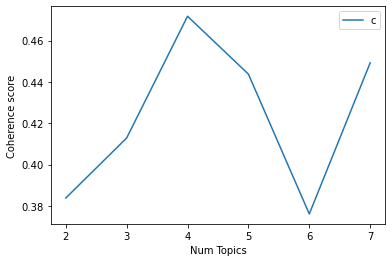

In [44]:
# Show graph
limit=8; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [45]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3838
Num Topics = 3  has Coherence Value of 0.4129
Num Topics = 4  has Coherence Value of 0.4718
Num Topics = 5  has Coherence Value of 0.4438
Num Topics = 6  has Coherence Value of 0.3761
Num Topics = 7  has Coherence Value of 0.4492


In [47]:
# Select the model and print the topics
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.029*"year" + 0.022*"music" + 0.021*"award" + 0.013*"number" + '
  '0.012*"show" + 0.012*"band" + 0.010*"song" + 0.010*"tv" + 0.010*"chart" + '
  '0.009*"world"'),
 (1,
  '0.023*"game" + 0.017*"time" + 0.016*"club" + 0.015*"age" + 0.015*"player" + '
  '0.014*"year" + 0.013*"executive" + 0.012*"life" + 0.011*"team" + '
  '0.008*"world"'),
 (2,
  '0.035*"figure" + 0.028*"law" + 0.015*"sale" + 0.014*"radio" + '
  '0.011*"minute" + 0.010*"wale" + 0.008*"measure" + 0.008*"side" + '
  '0.007*"nation" + 0.007*"feature"'),
 (3,
  '0.020*"people" + 0.014*"company" + 0.013*"firm" + 0.012*"service" + '
  '0.011*"year" + 0.010*"technology" + 0.010*"phone" + 0.010*"expectancy" + '
  '0.010*"market" + 0.009*"customer"'),
 (4,
  '0.081*"film" + 0.022*"winndixie" + 0.019*"game" + 0.015*"movie" + '
  '0.013*"food" + 0.011*"title" + 0.009*"director" + 0.008*"sale" + '
  '0.008*"drug" + 0.008*"child"'),
 (5,
  '0.022*"year" + 0.015*"government" + 0.012*"economy" + 0.011*"growth" + '
  '0.010*"co

`###### Other Hyperparameters ######`

`1.Number of Topics (K) document word matrox---`\
`2.Dirichlet hyperparameter alpha: Document-Topic Density--`\
`3. Dirichlet hyperparameter beta: Word-Topic Density`

In [49]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           chunksize=200,
                                           passes=10,
                                           alpha=a,
                                           eta=b,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [50]:
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 7
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

In [51]:
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results_new.csv', index=False)
    pbar.close()

 56%|█████▌    | 300/540 [40:43<32:35,  8.15s/it] 


In [53]:
#model_results

`### Make final model ###`

In [54]:
lda_model_final = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           chunksize=200,
                                           passes=10,  
                                            alpha=0.01,
                                            eta='symmetric',
                                      per_word_topics=True)

#passes: Number of passes through the entire corpus
#chunksize: Number of documents to load into memory at a time and process E step of EM.

In [55]:
pprint(lda_model_final.print_topics())
doc_lda = lda_model_final[corpus]

[(0,
  '0.033*"film" + 0.027*"year" + 0.019*"music" + 0.016*"award" + '
  '0.012*"number" + 0.011*"life" + 0.011*"winndixie" + 0.010*"band" + '
  '0.009*"actor" + 0.009*"director"'),
 (1,
  '0.031*"game" + 0.015*"time" + 0.013*"club" + 0.012*"player" + 0.012*"year" '
  '+ 0.011*"title" + 0.009*"team" + 0.008*"world" + 0.007*"side" + '
  '0.007*"week"'),
 (2,
  '0.022*"sale" + 0.019*"figure" + 0.012*"bank" + 0.012*"tv" + 0.011*"year" + '
  '0.008*"show" + 0.008*"people" + 0.008*"time" + 0.008*"film" + '
  '0.008*"child"'),
 (3,
  '0.033*"firm" + 0.019*"company" + 0.017*"business" + 0.016*"people" + '
  '0.015*"fiat" + 0.012*"year" + 0.011*"service" + 0.011*"profit" + '
  '0.011*"sale" + 0.011*"market"'),
 (4,
  '0.021*"year" + 0.017*"government" + 0.013*"economy" + 0.011*"growth" + '
  '0.010*"country" + 0.009*"people" + 0.009*"rate" + 0.008*"market" + '
  '0.008*"month" + 0.007*"company"')]


In [56]:
coherence_model_lda = CoherenceModel(model=lda_model_final, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4558717023450624


In [57]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model_final, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.207066  0.152890       1        1  29.128814
3      0.158620 -0.148061       2        1  26.217748
1     -0.085021  0.135270       3        1  17.298648
2     -0.051536 -0.162017       4        1  14.740668
0     -0.229128  0.021917       5        1  12.614122, topic_info=            Term         Freq        Total Category  logprob  loglift
2082        firm  1811.000000  1811.000000  Default  30.0000  30.0000
32          game  1225.000000  1225.000000  Default  29.0000  29.0000
250         film  1118.000000  1118.000000  Default  28.0000  28.0000
2347  government  1010.000000  1010.000000  Default  27.0000  27.0000
267         sale  1338.000000  1338.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
1555         age   134.685782   295.302975   Topic5  -5.2774   1.2853
177          day   150.799749   671.898786   Topic5  -5.1644   0.5762
64         world   142.868350   919.822904   Topic5  -5.2184   0.2081
153       people   144.144067  1871.313994   Topic5  -5.2095  -0.4932
132         time   141.745653  1408.573108   Topic5  -5.2263  -0.2259

[321 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
4764      2  0.990017  acquisition
3238      5  0.997782        actor
7975      5  0.992416      actress
1555      1  0.321703          age
1555      2  0.196408          age
...     ...       ...          ...
139       3  0.124069         year
139       4  0.094808         year
139       5  0.206880         year
5354      4  0.992179          yen
9623      1  0.989549         yuan

[533 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 2, 3, 1])

`#### Dorminant topics ###`

In [58]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [60]:
# import ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [61]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_final, corpus=corpus, texts=data)

In [62]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1,0.7258,"game, time, club, player, year, title, team, w...",chelsea sack mutu chelsea have sacked adrian m...
1,1,1,0.9092,"game, time, club, player, year, title, team, w...",record fails to lift lacklustre meet yelena is...
2,2,1,0.8842,"game, time, club, player, year, title, team, w...",edu describes tunnel fracas arsenals edu has l...
3,3,1,0.9381,"game, time, club, player, year, title, team, w...",ogara revels in ireland victory ireland flyhal...
4,4,1,0.9119,"game, time, club, player, year, title, team, w...",unclear future for striker baros liverpool for...
5,5,1,0.8950,"game, time, club, player, year, title, team, w...",ronaldo considering new contract manchester un...
6,6,1,0.9316,"game, time, club, player, year, title, team, w...",dawson wins england squad recall wasps scrumha...
7,7,1,0.9345,"game, time, club, player, year, title, team, w...",man utd through after exeter test manchester u...
8,8,1,0.9567,"game, time, club, player, year, title, team, w...",barkley fit for match in ireland england centr...
9,9,1,0.9603,"game, time, club, player, year, title, team, w...",bristol city milton keynes leroy lita took his...


#Topic distribution across documents
Finally, we want to understand the volume and distribution of topics:

In [63]:
df_topic_distribution = df_dominant_topic['Dominant_Topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Dominant_Topic', 'Num Documents']
df_topic_distribution.sort_values("Dominant_Topic")

,Dominant_Topic,Num Documents
3,0,355
1,1,547
4,2,171
2,3,542
0,4,795


In [66]:
# Wordcloud of Top N words in each topic
import wordcloud
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=2800,
                  max_words=15,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model_final.show_topics(formatted=False)

IndexError: list index out of range

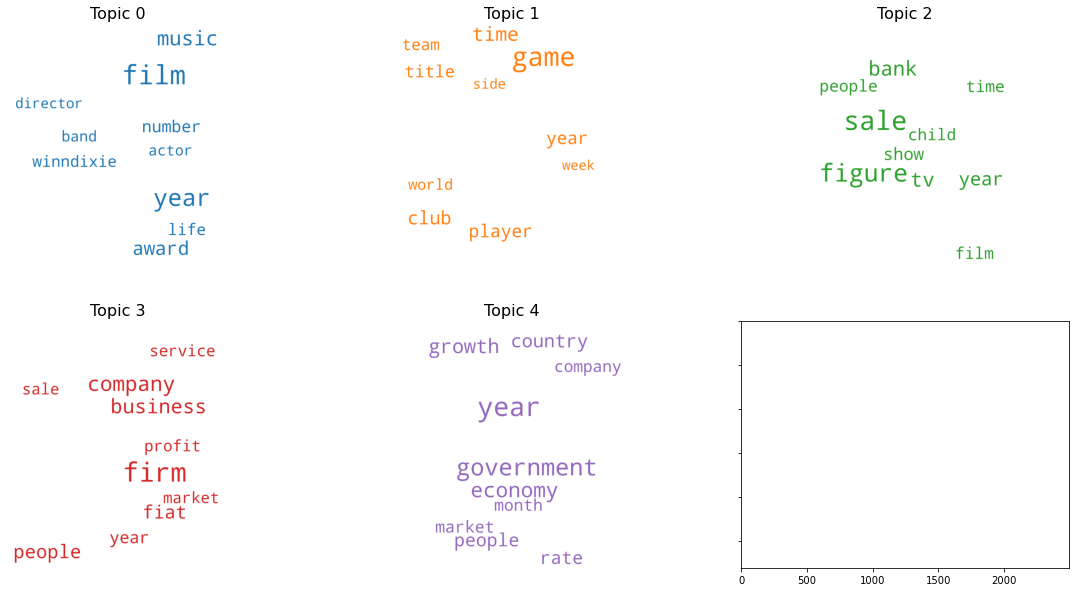

In [67]:
fig, axes = plt.subplots(2, 3, figsize=(20,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()